__Note:__
- Following notebook uses the oxford pets dataset which can be downloaded from https://www.robots.ox.ac.uk/~vgg/data/pets/
- Previous notebook includes some optimization techniques which can speed up your training process
- This notebook uses torchvision pretrained model VGG for transfer learning (There are multiple libraries which can be used for getting models for transfer learning for classification. This include torchvision, torch hub, timm, etc.)
- This notebook also have a comparison with mixed precision training

REFERENCES: 

1. https://github.com/rwightman/pytorch-image-models
2. https://pytorch.org/vision/stable/models.html
3. https://pytorch.org/hub/

# Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import kornia as K
from torch import optim
from torchsummary import summary
from torchvision import models
import random
from tqdm import tqdm

# For file and directory related operation
import os
import pathlib
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Setting Seed for reproducibility
seed = 42
random.seed(seed)
torch.manual_seed(seed)  
torch.cuda.manual_seed(seed)  
torch.cuda.manual_seed_all(seed)  
torch.backends.cudnn.deterministic = True

# Hyperparameters

In [2]:
# mean and std-dev taken from imagenet dataset
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
in_channels = 3
batch_size = 32
valid_size = 0.2
resize_side = 360
output_image_crop = (224, 224)
dropout_p = 0.0
img_aug_p = 0.5
learning_rate = 1e-04
epochs = 10

# Loading Data

In [3]:
base_path = pathlib.Path('./data/pets_dataset/images')
all_images = list(base_path.glob('./*.jpg'))
all_images[:10]

[PosixPath('data/pets_dataset/images/american_bulldog_143.jpg'),
 PosixPath('data/pets_dataset/images/yorkshire_terrier_176.jpg'),
 PosixPath('data/pets_dataset/images/pomeranian_98.jpg'),
 PosixPath('data/pets_dataset/images/yorkshire_terrier_1.jpg'),
 PosixPath('data/pets_dataset/images/Siamese_168.jpg'),
 PosixPath('data/pets_dataset/images/english_setter_86.jpg'),
 PosixPath('data/pets_dataset/images/keeshond_36.jpg'),
 PosixPath('data/pets_dataset/images/staffordshire_bull_terrier_19.jpg'),
 PosixPath('data/pets_dataset/images/Ragdoll_130.jpg'),
 PosixPath('data/pets_dataset/images/chihuahua_195.jpg')]

It is evident and also mentioned on the website of the dataset that the label of the image is in the file.

In [4]:
def get_label(fname):
    # Get filename without extension
    class_name = fname.stem
    # Remove the number from the file name
    class_ = class_name[:class_name.rfind('_')]
    return class_
print(all_images[0])
get_label(all_images[0])

data/pets_dataset/images/american_bulldog_143.jpg


'american_bulldog'

In [5]:
def clean_data(all_images):
    # Cleaning Data
    count = 0
    for img_path in tqdm(all_images):
        # Reading Error
        try:
            img = plt.imread(img_path)
        except:
            os.remove(img_path)
            count += 1
            continue
        # Grayscale image or has an alpha channel
        if len(img.shape) != 3 or img.shape[2] != 3:
            os.remove(img_path)
            count+=1
    print(f"Removed {count} images")
# clean_data(all_images)

In [6]:
unique_labels = list(set([get_label(fname) for fname in all_images]))
label_to_idx = {category:idx for idx, category in enumerate(unique_labels)}
print(f"Dataset Consists of {len(all_images)} images and {len(unique_labels)} categories")
print(unique_labels)

Dataset Consists of 7378 images and 37 categories
['american_pit_bull_terrier', 'japanese_chin', 'Sphynx', 'english_setter', 'samoyed', 'english_cocker_spaniel', 'miniature_pinscher', 'Maine_Coon', 'Birman', 'Persian', 'pug', 'saint_bernard', 'newfoundland', 'Egyptian_Mau', 'Ragdoll', 'Bengal', 'shiba_inu', 'scottish_terrier', 'wheaten_terrier', 'beagle', 'great_pyrenees', 'leonberger', 'Abyssinian', 'keeshond', 'yorkshire_terrier', 'american_bulldog', 'pomeranian', 'Siamese', 'havanese', 'chihuahua', 'german_shorthaired', 'boxer', 'Russian_Blue', 'basset_hound', 'staffordshire_bull_terrier', 'Bombay', 'British_Shorthair']


In [7]:
# Random split
random.shuffle(all_images)
valid_final_idx = int(valid_size * len(all_images))
valid_images = all_images[:valid_final_idx]
train_images = all_images[valid_final_idx:]
print(f"No of Training Examples: {len(train_images)} and No of Validation Examples: {len(valid_images)}")

No of Training Examples: 5903 and No of Validation Examples: 1475


In [8]:
# Augmentation
class Augmentation(nn.Module):
    def __init__(self, resize_img, output_crop, mean, 
                 std, aug_p = 0.5, train = True):
        
        super(Augmentation, self).__init__()
        self.train = train
        self.resize = K.augmentation.Resize(resize_img, side = 'long')
        self.padding = K.augmentation.PadTo((resize_img, resize_img))
        if train:
            deg_rot = 30
            translate = (0.1, 0.1)
            scale = (0.8,1.1)
            # same_on_batch = True to apply same transformation on batch
            self.affine_aug = K.augmentation.RandomAffine(deg_rot, translate, scale = scale, p = aug_p)
            self.horizontal_flip = K.augmentation.RandomHorizontalFlip(p = aug_p)
            
        self.cropping = K.augmentation.RandomCrop(output_crop, p =1.0)
        self.normalization = K.augmentation.Normalize(mean = mean, std = std)
    
    def forward(self, img):
        if self.train:
            img = self.affine_aug(self.horizontal_flip(self.resize(img)))
        img_aug = self.normalization(self.cropping(img))
        return img_aug

In [9]:
class PetsDataset(Dataset):
    def __init__(self, images_path, all_categories, label_to_idx, augment):
        self.images_path = images_path
        self.all_categories = all_categories
        self.label_to_idx = label_to_idx
        self.augment = augment
        
    def __len__(self):
        return len(self.images_path)
    
    def __getitem__(self, idx):
        img_name = self.images_path[idx]
        lbl = self.get_label(img_name)
        lbl = torch.tensor(lbl)
        img = plt.imread(img_name) / 255.
        img = torch.tensor(np.transpose(img, (2, 0, 1)))
        final_img = self.augment.padding(self.augment.resize(img))[0]
        return final_img, lbl
    
    def get_label(self, fname):
        class_name = fname.stem
        label = self.label_to_idx[class_name[:class_name.rfind('_')]]
        return label
    
    def batch_augmentation(self, batch):
        imgs, lbls = list(zip(*batch))
        imgs = torch.stack(imgs)
        lbls = torch.tensor(lbls)
        imgs = self.augment(imgs)
        return imgs, lbls

In [10]:
train_augmentation = Augmentation(resize_side, output_image_crop, mean, std, img_aug_p, train = True)
train_dataset = PetsDataset(all_images, unique_labels, label_to_idx, train_augmentation)
trainloader = DataLoader(train_dataset, batch_size = batch_size, num_workers = 8, pin_memory = True,
                         collate_fn=train_dataset.batch_augmentation, shuffle = True)

In [11]:
imgs, lbls = next(iter(trainloader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


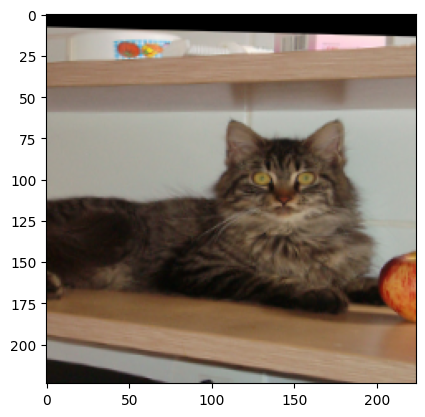

In [12]:
denorm = K.augmentation.Denormalize(mean =mean, std = std)
denorm_img = denorm(imgs[5])[0]
plt.imshow(np.transpose(denorm_img.cpu().detach().numpy(), (1,2,0)))

In [13]:
models.vgg16(weights = models.VGG16_Weights.DEFAULT)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

For transfer learning classifier has to be replaced with our own fc classifier and some layers has to be frozen (earlier layers specifically so as not to update earlier layers weight)

In [14]:
def get_data(aug_p = 0.5, bs = 64):
    train_augmentation = Augmentation(resize_side, output_image_crop, mean, std, img_aug_p, train = True)
    train_dataset = PetsDataset(train_images, unique_labels, label_to_idx, train_augmentation)
    trainloader = DataLoader(train_dataset, batch_size = batch_size, num_workers = 8, pin_memory = True,
                             collate_fn=train_dataset.batch_augmentation, shuffle = True)
    
    valid_augmentation = Augmentation(resize_side, output_image_crop, mean, std, img_aug_p, train = False)
    valid_dataset = PetsDataset(valid_images, unique_labels, label_to_idx, valid_augmentation)
    validloader = DataLoader(valid_dataset, batch_size = batch_size, num_workers = 8, pin_memory = True,
                             collate_fn=valid_dataset.batch_augmentation, shuffle = True)
    return trainloader, validloader

def get_model(dropout_prob, freeze = True, num_freeze = 29):
    model = models.vgg16(weights = models.VGG16_Weights.DEFAULT)
    if freeze:
        for idx, param in enumerate(model.parameters()):
            if idx <= num_freeze:
                param.requires_grad = False
                
    model.classifier = nn.Sequential(nn.Linear(in_features=25088, out_features = 1024),
                                    nn.ReLU(),
                                    nn.Dropout(dropout_prob),
                                    nn.Linear(1024, 37)) # Number of output categories is 37
    return model

def build_model(model, lr = 1e-03):
    optimizer = optim.Adam(model.parameters(), lr = lr)
    criterion = nn.CrossEntropyLoss()
    return optimizer, criterion

def train_batch(imgs, lbls, model, criterion, optimizer, valid = False):
    optimizer.zero_grad()
    imgs, lbls, model = imgs.to(device, non_blocking = True), lbls.to(device, non_blocking = True), model.to(device)
    out = model(imgs)
    batch_loss = criterion(out, lbls)
    if not valid:
        batch_loss.backward()
        optimizer.step()
    return batch_loss.item()

def no_of_correct(imgs, lbls, model):
    imgs, lbls, model = imgs.to(device, non_blocking = True), lbls.to(device, non_blocking = True), model.to(device)
    with torch.no_grad():
        model.eval()
        out = model(imgs)
        _, preds= out.max(-1)
        correct_preds = preds == lbls
        return correct_preds.cpu().numpy().sum(), len(lbls)

In [15]:
model = get_model(dropout_p, freeze = True, num_freeze = 29) # Set freeze = False to not freeze any layer
summary(model, torch.rand(32, 3, 224, 224));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

# Training (Without mixed precision)

In [19]:
def train(freeze = True):    
    trainloader, validloader = get_data(img_aug_p, batch_size)
    model = get_model(dropout_p, freeze = freeze, num_freeze = 16)
    optimizer, criterion = build_model(model, lr = learning_rate)
    train_accuracies, valid_accuracies = [], []
    train_losses, valid_losses = [], []
    for epoch in range(epochs+1):
        batch_loss = 0.0
        model.train()
        pbar = tqdm(trainloader, total = len(trainloader), leave = False)
        for imgs, lbls in pbar:
            imgs = imgs.to(torch.float32)
            current_batch_loss = train_batch(imgs, lbls, model, criterion, optimizer)
            batch_loss += current_batch_loss
            pbar.set_postfix(train_loss = current_batch_loss)

        total_correct = 0
        total = 0
        for imgs, lbls in trainloader:
            imgs = imgs.to(torch.float32)
            batch_correct, batch_total = no_of_correct(imgs, lbls, model)
            total_correct += batch_correct
            total += batch_total

        epoch_train_acc = total_correct/total
        train_accuracies.append(epoch_train_acc)
        epoch_train_loss = batch_loss / len(trainloader)
        train_losses.append(epoch_train_loss)

        # Calculating for Valid data
        batch_loss = 0.0
        total_correct = 0
        total = 0
        for imgs, lbls in validloader:
            imgs = imgs.to(torch.float32)
            batch_loss += train_batch(imgs, lbls, model, criterion, optimizer, valid = True)
            batch_correct, batch_total = no_of_correct(imgs, lbls, model)
            total_correct += batch_correct
            total += batch_total


        epoch_valid_loss = batch_loss / len(validloader)
        epoch_valid_acc = total_correct / total
        valid_losses.append(epoch_valid_loss)
        valid_accuracies.append(epoch_valid_acc)

        print(f"{'*'*10} EPOCH {epoch:2}/{epochs} {'*'*10}")
        print(f'''{"#"*33}
Train Loss: {epoch_train_loss:5.3f}, Train Accuracy: {epoch_train_acc*100:5.2f}
Valid Loss: {epoch_valid_loss:5.3f}, Valid Accuracy: {epoch_valid_acc*100:5.2f}
{"#"*33}''')
    return model, train_losses, train_accuracies, valid_losses, valid_accuracies

In [20]:
model, train_losses, train_accuracies, valid_losses, valid_accuracies = train(freeze = True)

********** EPOCH  0/10 **********
#################################
Train Loss: 1.207, Train Accuracy: 77.38
Valid Loss: 0.882, Valid Accuracy: 71.59
#################################


********** EPOCH  1/10 **********
#################################
Train Loss: 0.630, Train Accuracy: 80.82
Valid Loss: 0.842, Valid Accuracy: 74.24
#################################


********** EPOCH  2/10 **********
#################################
Train Loss: 0.555, Train Accuracy: 85.11
Valid Loss: 0.712, Valid Accuracy: 78.58
#################################


********** EPOCH  3/10 **********
#################################
Train Loss: 0.405, Train Accuracy: 87.40
Valid Loss: 0.668, Valid Accuracy: 78.10
#################################


********** EPOCH  4/10 **********
#################################
Train Loss: 0.325, Train Accuracy: 88.16
Valid Loss: 0.645, Valid Accuracy: 80.47
#################################


********** EPOCH  5/10 **********
#################################
Train Loss: 0.454, Train Accuracy: 89.36
Valid Loss: 0.769, Valid Accuracy: 77.63
#################################


********** EPOCH  6/10 **********
#################################
Train Loss: 0.288, Train Accuracy: 92.39
Valid Loss: 0.723, Valid Accuracy: 80.95
#################################


********** EPOCH  7/10 **********
#################################
Train Loss: 0.327, Train Accuracy: 91.22
Valid Loss: 0.682, Valid Accuracy: 80.41
#################################


********** EPOCH  8/10 **********
#################################
Train Loss: 0.269, Train Accuracy: 90.80
Valid Loss: 0.730, Valid Accuracy: 80.14
#################################


********** EPOCH  9/10 **********
#################################
Train Loss: 0.276, Train Accuracy: 90.23
Valid Loss: 0.632, Valid Accuracy: 80.75
#################################


********** EPOCH 10/10 **********
#################################
Train Loss: 0.316, Train Accuracy: 92.66
Valid Loss: 0.610, Valid Accuracy: 82.44
#################################


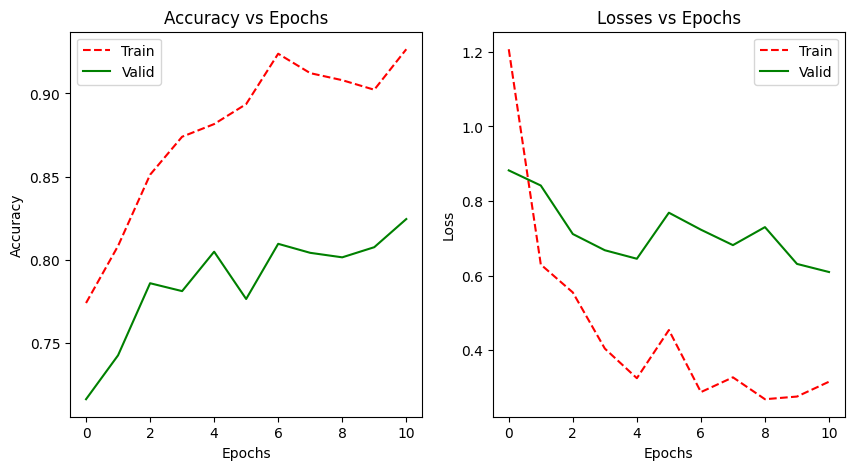

In [21]:
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_accuracies, 'r--', label = 'Train')
plt.plot(valid_accuracies, 'g-', label = 'Valid')
plt.legend()
plt.subplot(122)
plt.title('Losses vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_losses, 'r--', label = 'Train')
plt.plot(valid_losses, 'g-', label = 'Valid')
plt.legend();

The model is now unfreezed and trained with a smaller learning rate for finer training and improve model. Also with a bit of regularization